In [17]:
from glob import glob
import os
from pathlib import Path
import shutil
import urllib.request as request
from contextlib import closing

import matplotlib.pyplot as plt
import pygrib
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
from metpy.units import units
from datetime import datetime
from dateutil import tz

In [18]:
grib_dir = Path('.') / 'data'
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'in-situ'

In [5]:
# Download files

date = 20210224
run = '1000'
left_lon = 360-90
right_lon = 360-77
top_lat = 36
bottom_lat = 24

nomads_url = ('https://nomads.ncep.noaa.gov/cgi-bin/filter_rtma_ru.pl?'
              f'file=rtma2p5_ru.t{run}z.2dvarges_ndfd.grb2'
              '&all_lev=on&lev_2_m_above_ground=on&all_var=on&'
              f'subregion=&leftlon={left_lon}&rightlon={right_lon}&toplat={top_lat}&bottomlat={bottom_lat}&'
              f'dir=%2Frtma2p5_ru.{date}')

def download_gribfilter(file_url: str):
    with closing(request.urlopen(file_url)) as r:
        with open(f'{grib_dir}/current.grib2', 'wb') as f:
            shutil.copyfileobj(r, f)
        
download_gribfilter(nomads_url)

In [23]:
ds = pygrib.open(f'{grib_dir}/current.grib2')
ds.seek(0)

ds = temp_2m = ds[3]
lats, lons = ds.latlons()
temperatures = ds.values * units.kelvin
temperatures = temperatures.to('degF')

In [40]:
def get_gridpoint_value(lat_of_interest: float, lon_of_interest: float) -> int:
    '''
    Calculate the closest gridpoint value to a given latitude
    and longitude.
    '''
    abs_lat = np.abs(lats - lat_of_interest)
    abs_lon = np.abs(lons - lon_of_interest)
    
    overlap_latlon = np.maximum(abs_lon, abs_lat)
    latlon_idx = np.argmin(overlap_latlon)
    
    temperature_1d = temperatures.flatten()
    
    return temperature_1d[latlon_idx].astype(int)


kgnv = np.round(get_gridpoint_value(29.65, -82.32))
print(kgnv)
kpns = np.round(get_gridpoint_value(30.4213, -87.2169)).astype(int)
print(kpns)
ktlh = np.round(get_gridpoint_value(30.4383, -84.2807)).astype(int)
kjax = np.round(get_gridpoint_value(30.3322, -81.6557)).astype(int)
ktpa = np.round(get_gridpoint_value(27.9506, -82.4572)).astype(int)
kmco = np.round(get_gridpoint_value(28.5383, -81.3792)).astype(int)
kfmy = np.round(get_gridpoint_value(26.6406, -81.8723)).astype(int)
kmia = np.round(get_gridpoint_value(25.7617, -80.1918)).astype(int)

# SC cities
kcae = np.round(get_gridpoint_value(34.0007, -81.0348)).astype(int)
kmyr = np.round(get_gridpoint_value(33.6891, -78.8867)).astype(int)
kchs = np.round(get_gridpoint_value(32.7765, -79.9311)).astype(int)
kgsp = np.round(get_gridpoint_value(34.8526, -82.3940)).astype(int)
kuza = np.round(get_gridpoint_value(34.9249, -81.0251)).astype(int)

43 degree_Fahrenheit
49 degree_Fahrenheit


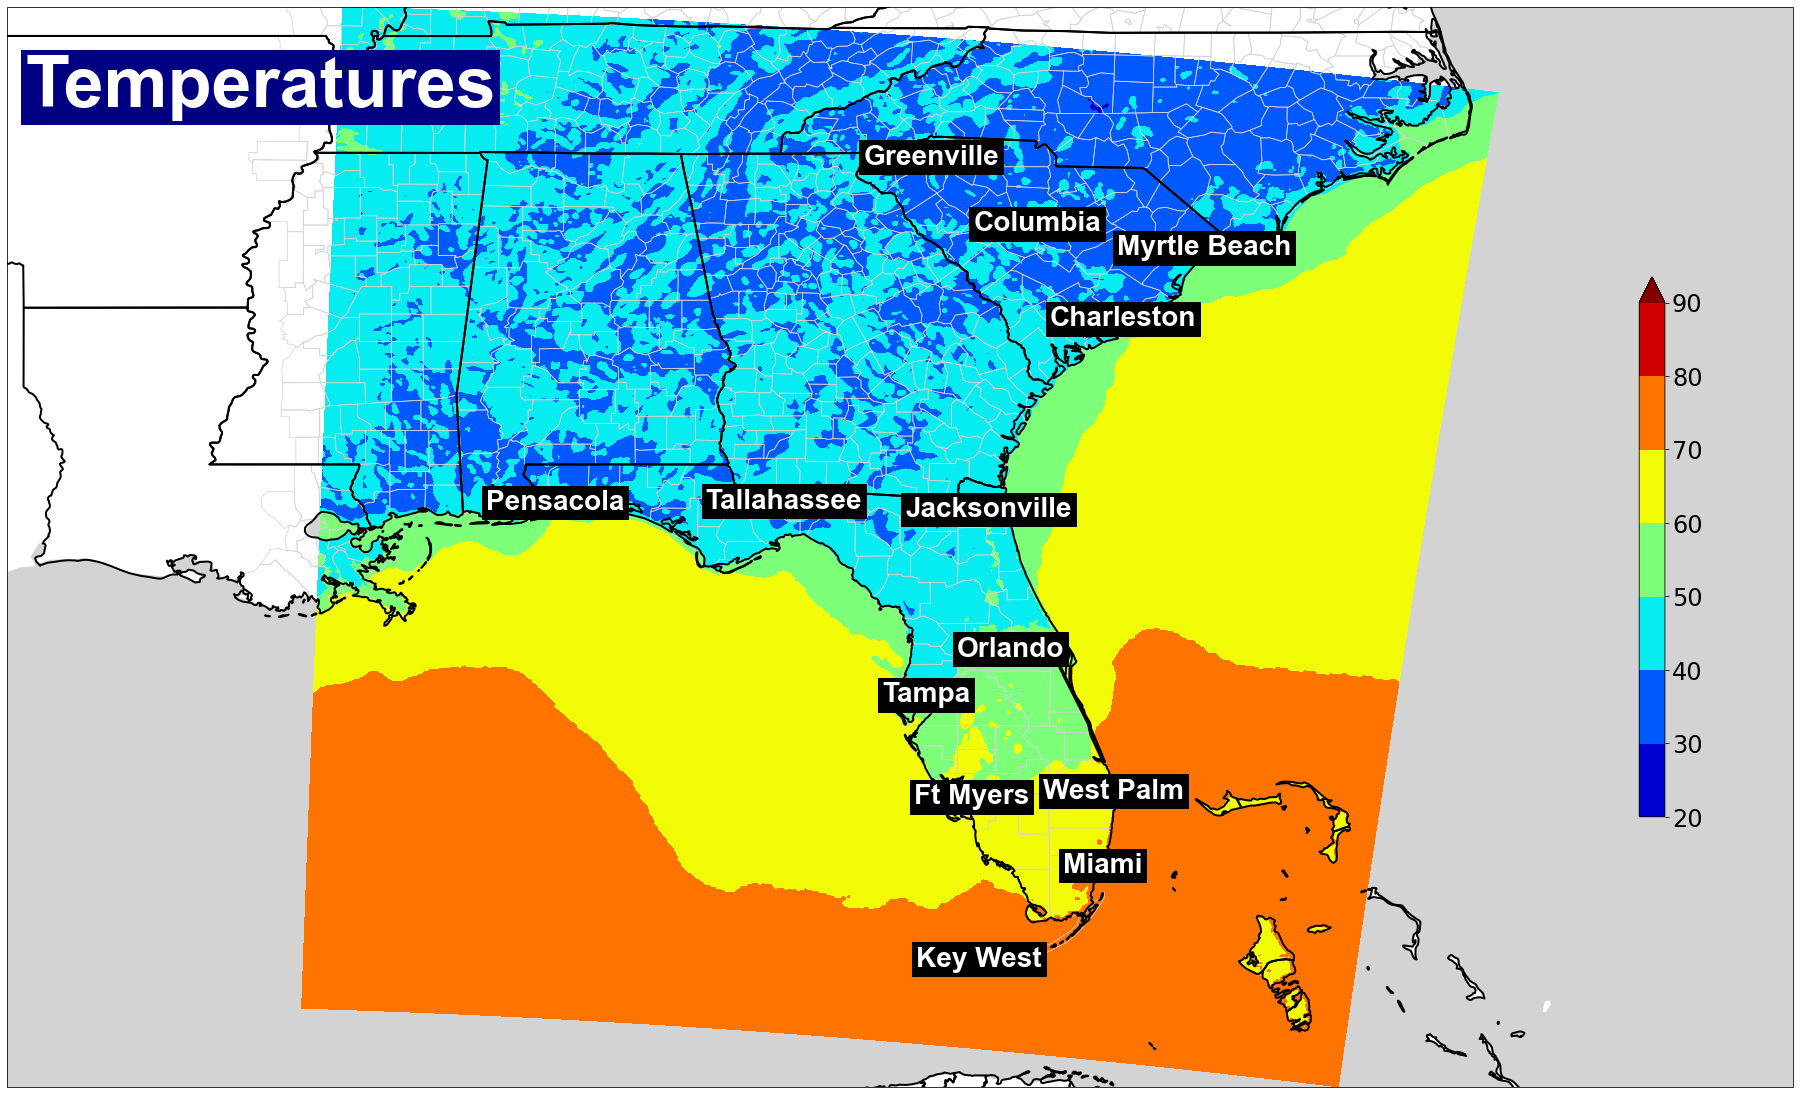

In [41]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)
ax.set_adjustable('datalim')
#ax.set_extent([-82, -79, 31, 36])
#ax.set_extent([-87, -80, 23.5, 32])

data_range = [num for num in np.arange(20, 100, 10)]
contour = ax.contourf(lons, lats, temperatures, data_range, cmap=plt.cm.jet, 
                      extend='max', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='vertical', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

def plot_cities(lat, lon, city_name):
    ax.text(lon, lat, city_name, fontsize=28, zorder=10, fontweight='bold', fontname='Arial', backgroundcolor='black',
            color='white', ha='center', transform=ccrs.PlateCarree())
    
def plot_rain_amounts(lat, lon):
    rainfall_point = ds.paramId_0.metpy.sel(lat=lat, lon=360+lon, method='nearest')
    rainfall_point = np.round((rainfall_point / 25.4).values, decimals=2)
    
    plt.text(lon-0.20, lat+0.25, s=f'{rainfall_point}"', color='black',
             transform=ccrs.PlateCarree(), zorder=3, fontsize=32, fontname='Arial', va='bottom',
             bbox={'facecolor':'white', 'alpha':1.0, 'edgecolor': 'none'})
    
# Plot cities
cities = {
    'Pensacola': [30.4213, -87.2169],
    #'Panama City': [30.1766, -85.8055],
    'Tallahassee': [30.4383, -84.2807],
    'Jacksonville': [30.3322, -81.6557],
    #'Gainesville': [29.6516, -82.3248],
    'Tampa': [27.9506, -82.4572],
    'Orlando': [28.5383, -81.3792],
    #'Ft Pierce': [27.4467, -80.3256],
    'West Palm': [26.7153, -80.0534],
    'Ft Myers': [26.6406, -81.8723],
    'Miami': [25.7617, -80.1918],
    'Key West': [24.5551, -81.7800],
    'Greenville': [34.8526, -82.3940],
    #'Rock Hill': [34.9249, -81.0251],
    'Columbia': [34.0007, -81.0348],
    #'Florence': [34.1954, -79.7626],
    'Myrtle Beach': [33.6891, -78.8867],
    'Charleston': [32.7765, -79.9311],
    #'Aiken': [33.5604, -81.7196],
    #'Sumter': [33.9204, -80.3415],
    #'Orangeburg': [33.4918, -80.8556],
    #'Hilton Head': [32.2163, -80.7526],
    #'Greenwood': [34.1954, -82.1618]
}

for city in cities.keys():
    plot_cities(cities[city][0], cities[city][1], city)
    get_gridpoint_value(cities[city][0], cities[city][1])

# Make the axis title
ax.set_title(f'Temperatures', loc='left', 
             ha='left', va='top', fontsize=72, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Save and show figure
plt.savefig(f'{graphics_dir}/temperatures.png', dpi=72)
plt.show()